# Debugging My PyTorch Pipeline

In my original ML code, I have a 4-file process: 
1) `configs.json`: JSON file defining file paths and the different input-variable configurations for running my NN models
2) `model.py`: defines the NN model architecture and forward pass
3) `train.py`: trains and validates the NN model
4) `eval.py`: evaluates the model and saves predictions to a NetCDF file

To debug this code, I created dummy data that’s deliberately easy for a NN to learn so I can verify that my pipeline (configs → model → train → eval) is set up correctly.

## The Dummy Data

`x` is a 3D field with dimensions (time, lat, lon). It is synthetic but structured: it is a smooth sinusoid in time (daily oscillation) with weak latitudinal and longitudinal gradients, and has a small amount of Gaussian noise. `y` is defined from `x` via a simple linear mapping:
$$ y = 3x + 1.5 $$
so `y` has the same shape (time, lat, lon) as `x`. Because this relationship is deterministic and linear, a simple NN should learn it very quickly. If it doesn’t, the issue is the pipeline rather than model's capacity to make accurate predictions.

## Data Splits

I used the same South Asian monsoon region as my original data (5-25$^\circ$N, 60-90$^\circ$E) with daily frequency. The training set is 7,000 time steps (starting 1/1/2000) and the validation set is 3,000 time steps (which starts the day after training period ends; no temporal overlap).

## NN Model Architecture

Just like the original pipeline, we flatten the 3D data into a 1D vector of length (time $\times$ lat $\times$ lon). We then pass it through this simpler NN:
```
Linear(1 → 128)  → SiLU
Linear(128 → 64) → SiLU
Linear(64 → 32)  → SiLU
Linear(32 → 1)
```
All other model parameters (e.g., loss function, learning rate) and training artifacts (e.g., early stopping) remain the same.

## Import Necessary Packages

In [4]:
import os
import json
import warnings
import numpy as np
import xarray as xr
import proplot as pplt
pplt.rc['reso']='xx-hi'
pplt.rc['figure.dpi'] = 100
warnings.filterwarnings('ignore')

## User-Defined Fields

In [5]:
with open('configs.json','r',encoding='utf8') as f:
    CONFIGS = json.load(f)
FILEDIR    = CONFIGS['paths']['filedir']
RESULTSDIR = CONFIGS['paths']['resultsdir']

## Examining Training & Validation Losses

Using the same training/validation loops as my original pipeline, I logged losses to Weights & Biases. As expected for this task, training loss drops to near-zero within a few epochs and then plateaus at numerical noise. Validation loss follows closely and levels off as well. Minor per-epoch jitter is normal (batching and optimizer step noise). Since training looks healthy, I evaluated the NN on the validation set to produce predicted `y`.

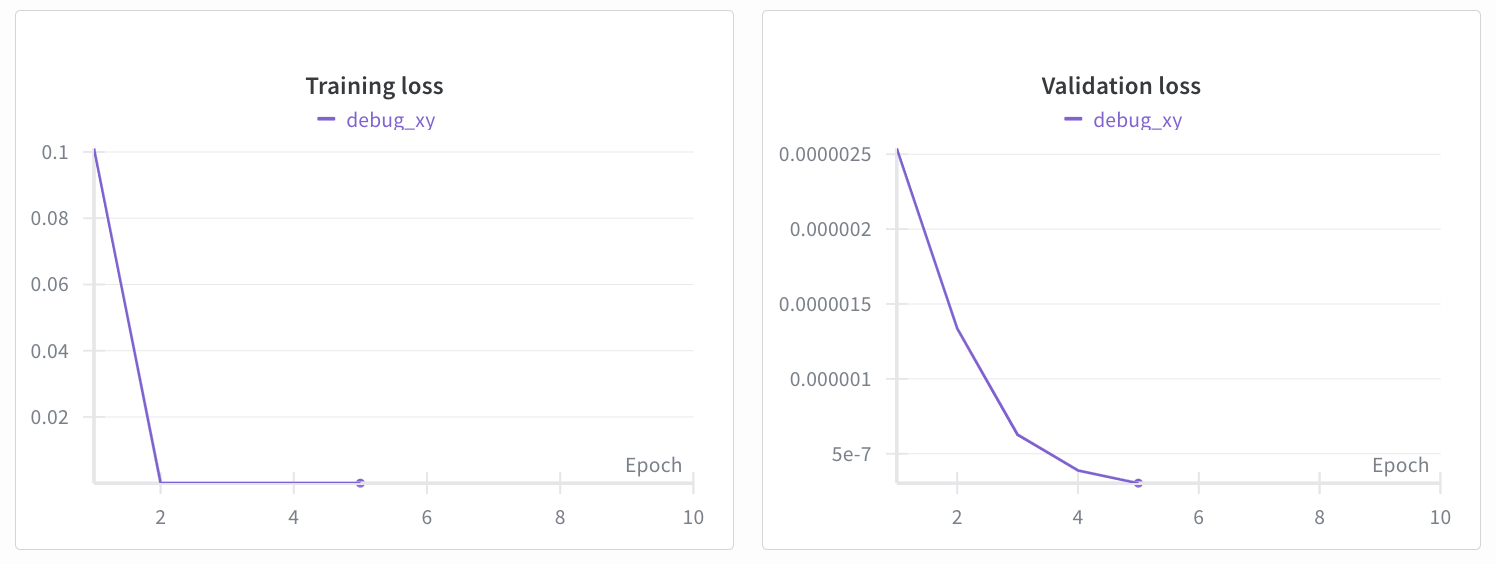

## Import the True and Predicted Validation Set Data

In [11]:
trueds = xr.open_dataset(os.path.join(FILEDIR,'debug_valid.h5'),engine='h5netcdf')
predds = xr.open_dataset(os.path.join(RESULTSDIR,'nn_debug_xy_debug_valid_y.nc'),engine='h5netcdf')

xtrue = trueds['x']
ytrue = trueds['y']
ypred = predds['ypred']

## Compare Actual vs. Predicted `y`

Below, I plot maps of `x`, `y_true`, `y_pred`, and the error (`y_pred - y_true`) for: a) a sample day from the validation set (3/2/2019), and b) the time-mean over the validation period. In both the noisier daily snapshot and the time-mean, `y_pred` visually matches `y_true`, and the error map is near-zero.

I also plot a scatter of `y_true` vs. `y_pred` with a 1:1 line. Points fall tightly on the line. I compute MSE, MAE, and R² over the validation set; MSE and MAE are ~0 and R² ≈ 1, confirming that the pipeline reproduces the known linear mapping.

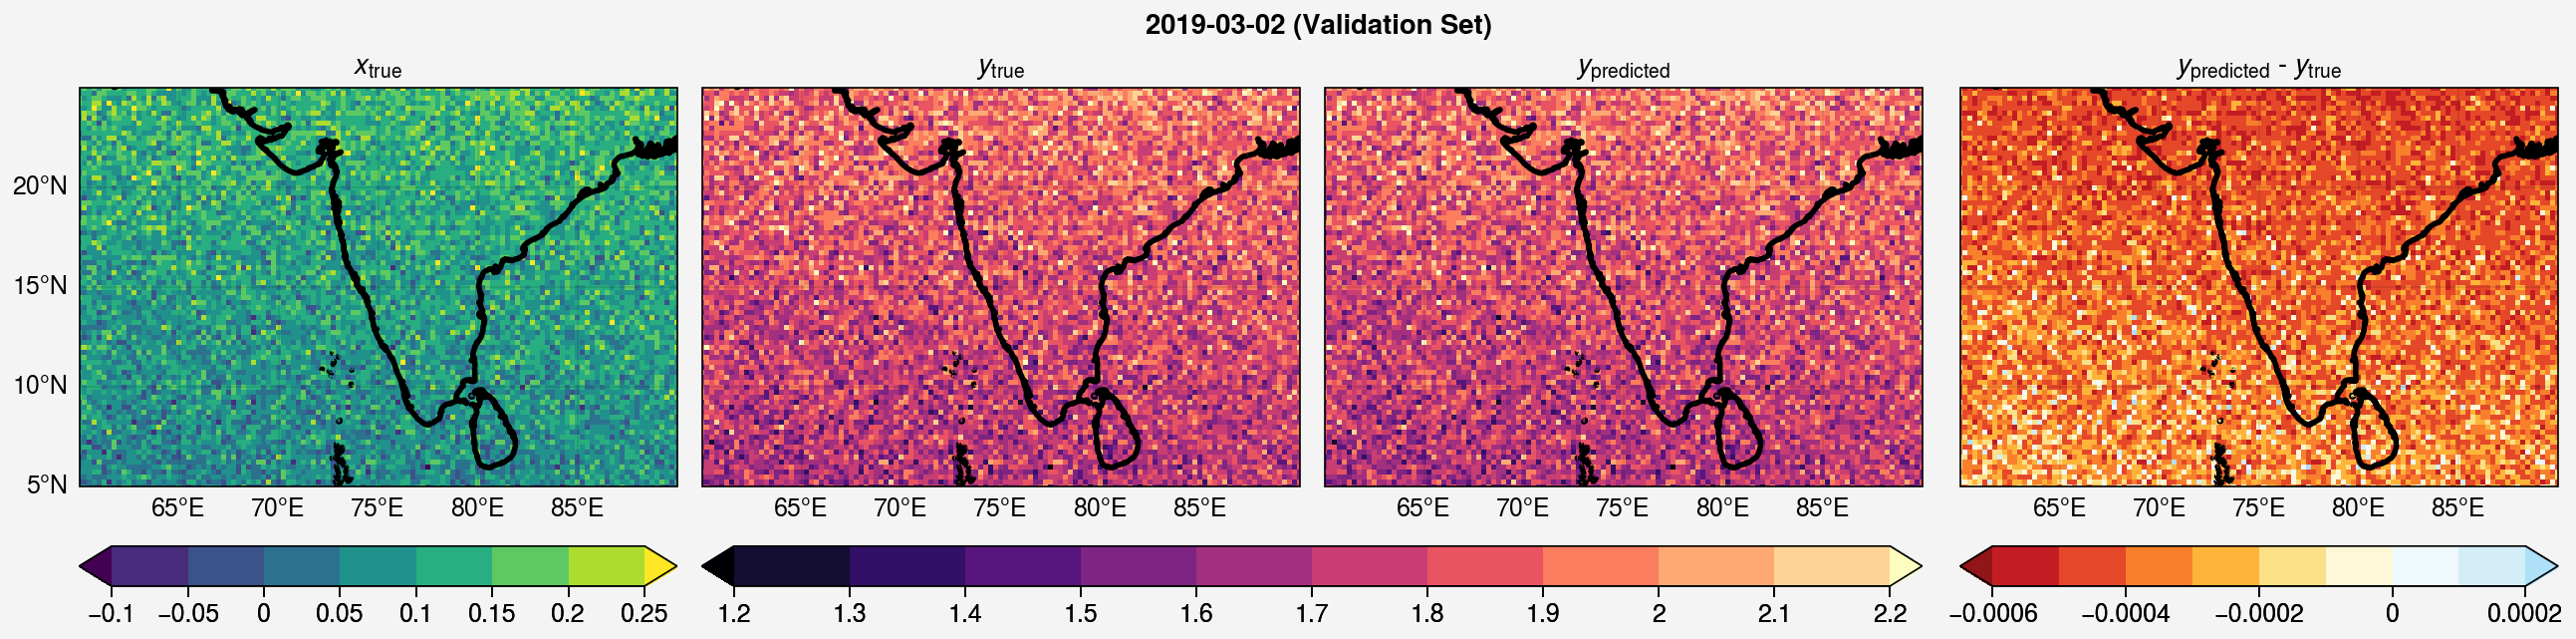

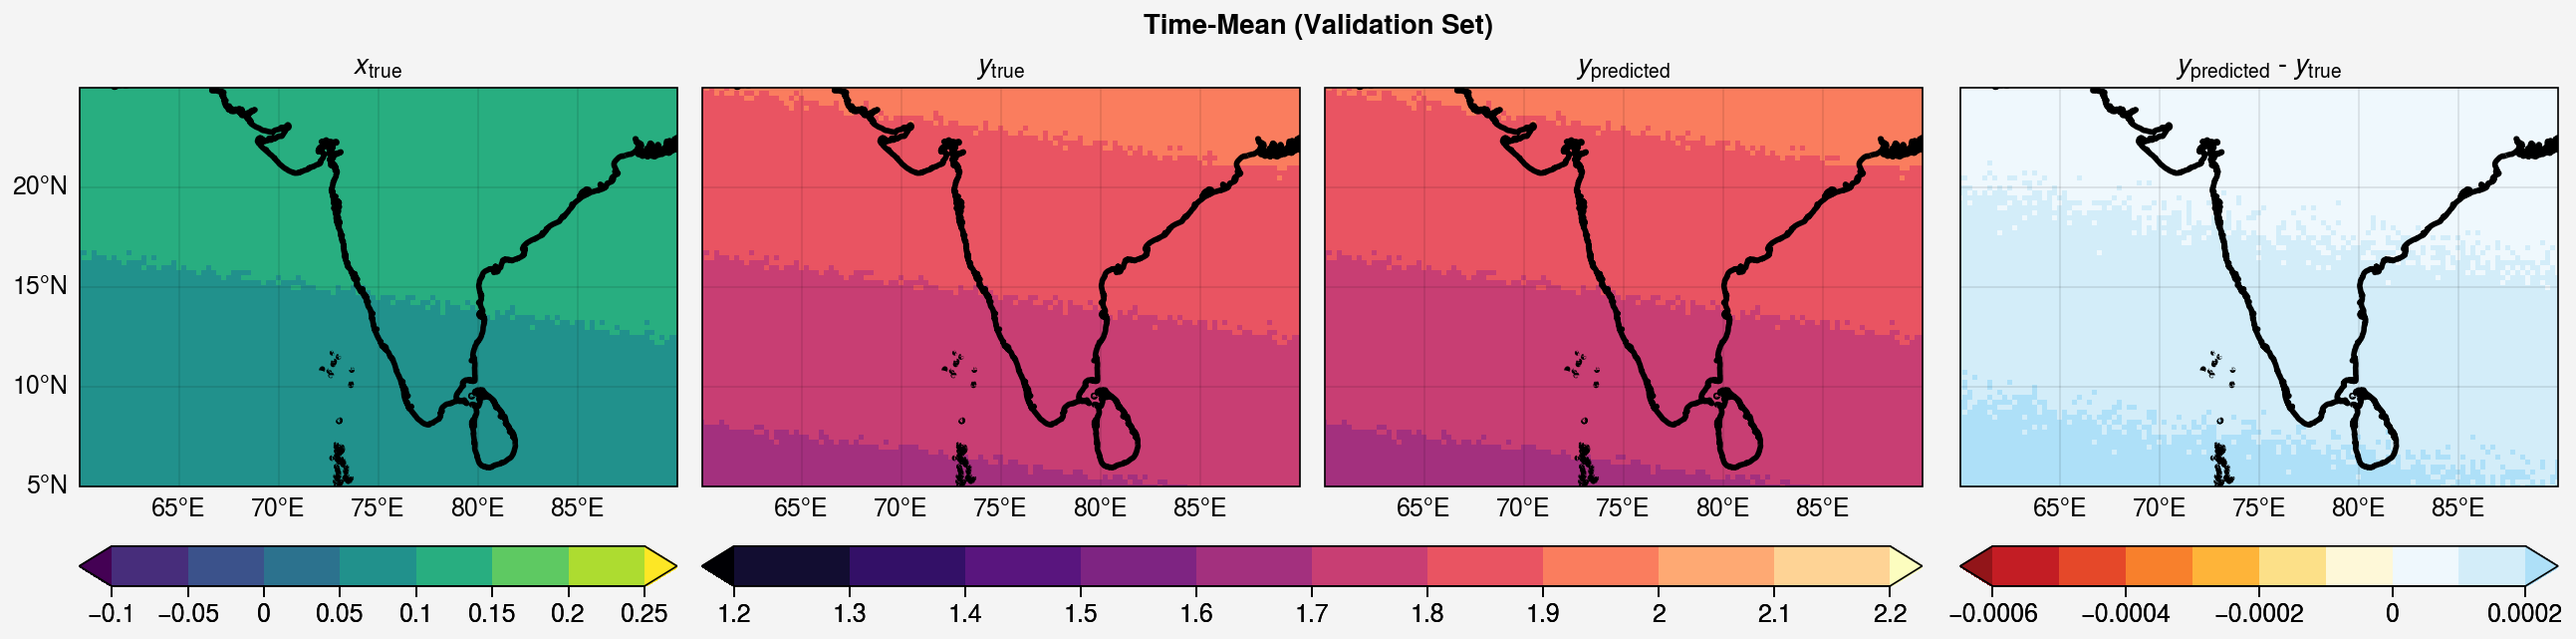

In [109]:
fig,axs = pplt.subplots(nrows=1,ncols=4,refwidth=3,proj='cyl')
axs.format(suptitle='2019-03-02 (Validation Set)',coast=True,coastlinewidth=2,
           latlim=(5.,25.),latlines=[5,10,15,20],lonlim=(60.,90.),lonlines=5,lonlabels='b')
axs[0].format(title='$\mathit{x}_{true}$',latlabels='l')
axs[1].format(title='$\mathit{y}_{true}$')
axs[2].format(title='$\mathit{y}_{predicted}$')
axs[3].format(title='$\mathit{y}_{predicted}$ - $\mathit{y}_{true}$')
m0 = axs[0].pcolormesh(xtrue.isel(time=0),cmap='viridis',vmin=-0.1,vmax=0.3,levels=9,extend='both')
m1 = axs[1].pcolormesh(ytrue.isel(time=0),cmap='magma',vmin=1.2,vmax=2.2,levels=12,extend='both')
m2 = axs[2].pcolormesh(ypred.isel(time=0),cmap='magma',vmin=1.2,vmax=2.2,levels=12,extend='both')
m3 = axs[3].pcolormesh(ypred.isel(time=0)-ytrue.isel(time=0),cmap='ColdHot_r',vmin=-0.00061,vmax=0.00021,
                       levels=10,extend='both')
fig.colorbar(m0,loc='b',cols=1,label='')
fig.colorbar(m1,loc='b',cols=(2,3),label='')
fig.colorbar(m3,loc='b',cols=4,label='',ticks=0.0002)
pplt.show()

fig,axs = pplt.subplots(nrows=1,ncols=4,refwidth=3,proj='cyl')
axs.format(suptitle='Time-Mean (Validation Set)',coast=True,coastlinewidth=2,
           latlim=(5.,25.),latlines=[5,10,15,20],lonlim=(60.,90.),lonlines=5,lonlabels='b')
axs[0].format(title='$\mathit{x}_{true}$',latlabels='l')
axs[1].format(title='$\mathit{y}_{true}$')
axs[2].format(title='$\mathit{y}_{predicted}$')
axs[3].format(title='$\mathit{y}_{predicted}$ - $\mathit{y}_{true}$')
m0 = axs[0].pcolormesh(xtrue.mean('time'),cmap='viridis',vmin=-0.1,vmax=0.3,levels=9,extend='both')
m1 = axs[1].pcolormesh(ytrue.mean('time'),cmap='magma',vmin=1.2,vmax=2.2,levels=12,extend='both')
m2 = axs[2].pcolormesh(ypred.mean('time'),cmap='magma',vmin=1.2,vmax=2.2,levels=12,extend='both')
m3 = axs[3].pcolormesh(ypred.mean('time')-ytrue.mean('time'),cmap='ColdHot_r',vmin=-0.00061,vmax=0.00021,
                       levels=10,extend='both')
fig.colorbar(m0,loc='b',cols=1,label='')
fig.colorbar(m1,loc='b',cols=(2,3),label='')
fig.colorbar(m3,loc='b',cols=4,label='',ticks=0.0002)
pplt.show()

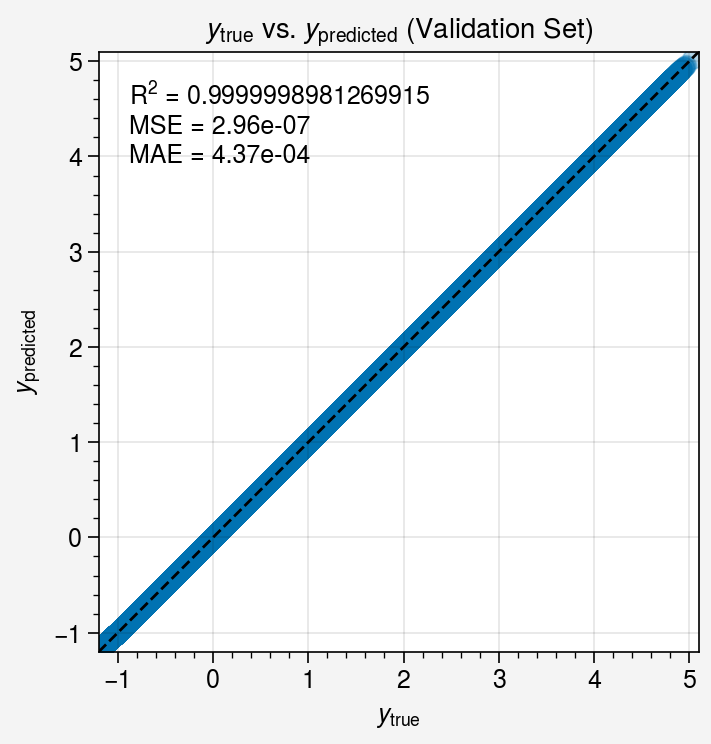

In [123]:
ytrueflat = ytrue.values.ravel()
ypredflat = ypred.values.ravel()
mask      = np.isfinite(ytrueflat)&np.isfinite(ypredflat)
ytrueflat = ytrueflat[mask]
ypredflat = ypredflat[mask]

mse = float(((ypred-ytrue)**2).mean().values)
mae = float((abs(ypred-ytrue)).mean().values)
rss = float(np.sum((ytrue.values.reshape(-1)-ypred.values.reshape(-1))**2))
tss = float(np.sum((ytrue.values.reshape(-1)-ytrue.values.reshape(-1).mean())**2))
r2  = 1.0-(rss/tss)

fig,ax = pplt.subplots(nrows=1,ncols=1,refwidth=3)
ax.format(title='$\mathit{y}_{true}$ vs. $\mathit{y}_{predicted}$ (Validation Set)',
          xlabel='$\mathit{y}_{true}$',xlim=(-1.2,5.1),
          ylabel='$\mathit{y}_{predicted}$',ylim=(-1.2,5.1))
ax.scatter(ytrueflat,ypredflat,markersize=50,alpha=0.3)
ax.plot([-1.2,5.1],[-1.2,5.1],linewidth=1,linestyle='--',color='k')
ax.text(0.05,0.95,f'R$^2$ = {r2}\nMSE = {mse:.2e}\nMAE = {mae:.2e}',transform=ax.transAxes,va='top')
pplt.show()